In [1]:
!pip install -q seaborn

In [2]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.5.0


In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 4us/step


'/root/.keras/datasets/auto-mpg.data'

In [4]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [5]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [6]:
dataset = dataset.dropna()

In [7]:
origin = dataset.pop('Origin')

In [8]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [9]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

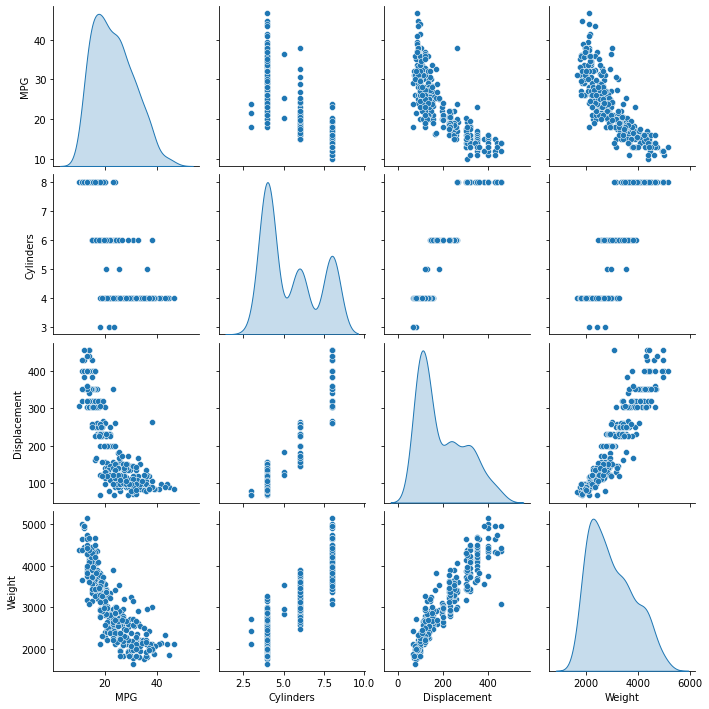

In [11]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [12]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [13]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [14]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [16]:
model = keras.Sequential(
    [
     layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
     layers.Dense(64, activation='relu'),
     layers.Dense(1),
    ]
)

optimizer = tf.keras.optimizers.RMSprop(0.001)

model.compile(
    loss="mse",
    optimizer=optimizer,
    metrics=["mae", "mse"],
)

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [18]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.00783136],
       [0.33403835],
       [0.2717864 ],
       [0.187469  ],
       [0.6033918 ],
       [0.23507345],
       [0.6818191 ],
       [1.1142161 ],
       [0.1689848 ],
       [0.6718676 ]], dtype=float32)

In [19]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print()
        print('.', end='')

EPOCHS = 1000

history = model.fit(
    normed_train_data,
    train_labels,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=0,
    callbacks=[PrintDot()],
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.599429,1.057774,2.599429,8.924720,2.299958,8.924720,995
996,2.364362,1.000363,2.364362,9.387496,2.348083,9.387496,996
997,2.486733,1.040621,2.486733,9.651244,2.391301,9.651244,997
998,2.482682,1.037785,2.482682,9.196731,2.322890,9.196731,998
999,2.571949,1.059136,2.571949,8.823359,2.266583,8.823359,999


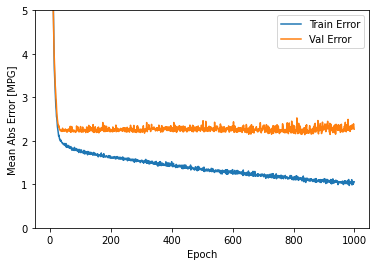

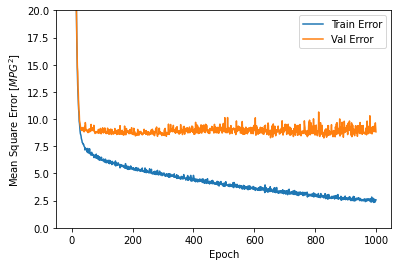

In [21]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()


plot_history(history)


......................................................................................

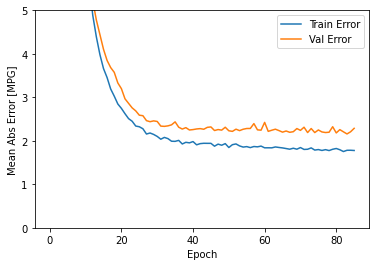

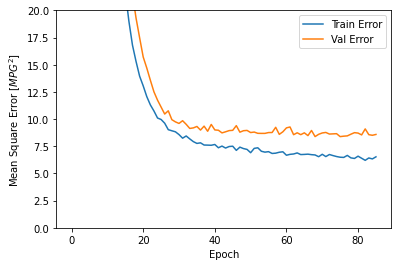

In [22]:
# with early stop
model = keras.Sequential(
    [
     layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
     layers.Dense(64, activation='relu'),
     layers.Dense(1),
    ]
)

optimizer = tf.keras.optimizers.RMSprop(0.001)

model.compile(
    loss="mse",
    optimizer=optimizer,
    metrics=["mae", "mse"],
)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
    normed_train_data,
    train_labels,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=0,
    callbacks=[early_stop, PrintDot()]
)

plot_history(history)

In [23]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.6270 - mae: 1.7656 - mse: 5.6270
Testing set Mean Abs Error:  1.77 MPG


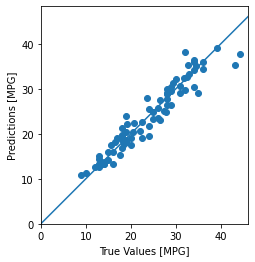

In [24]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

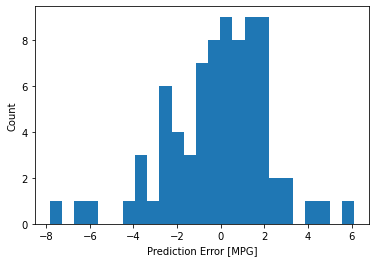

In [25]:
# 誤差の分布
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

In [ ]:
# 平均二乗誤差（MSE）は回帰問題で使われる一般的な損失関数
# 平均絶対誤差（MAE）は回帰問題で使われる一般的な評価指標
# 入力の特徴量の値域が異なっているなら特徴量ごとに同じ値域になるように正規化すべき
# 訓練データが少ないなら，あまり深くないネットワークを使うというのも過学習を防ぐ上で有効
# Early Stopppingは過学習を防止する便利な手法の一つ